<a href="https://colab.research.google.com/github/difkrit/DSI314-association_rules/blob/main/DSI314_associations_rules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DSI314 Associations rules (Turmeric) from Twitter and Facebook**

clone ข้อมูลที่ต้องการ และ install library ที่ต้องการ


In [ ]:
!git clone https://github.com/difkrit/DSI314-association_rules

!pip install apyori
!pip install pythainlp
!pip install epitran
!pip install sklearn_crfsuite
!pip install tensorflow deepcut
!pip install attacut
!pip install wordcloud

Import library

In [2]:
try:
    %tensorflow_version 2.x
except:
    pass
import pandas as pd
import numpy as np
import re
import string
from apyori import apriori 
from mlxtend.frequent_patterns import association_rules

import warnings
warnings.filterwarnings('ignore')

import pythainlp
from pythainlp import sent_tokenize, word_tokenize


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


Import ข้อมูล Twitter และ Facebook แสดงตัวอย่างข้อมูลที่จะนำไปทำโมเตล 

In [3]:
df1 = pd.read_csv('/content/DSI314-association_rules/twt pop.csv')
df2 = pd.read_excel('/content/DSI314-association_rules/fb.xlsx')
df = pd.concat([df1, df2])
show = df.loc[:, ['Text']]
show.head(10)

,Text
0,ก่อนหมดคืนนี้ไป แอดอยากมาแก้ข่าวก่อน\nทุกคนค้า...
1,เปิดตัวแล้วจ้า ผลิตภัณฑ์ใหม่ล่าสุดจากวิฟสกินผิ...
2,สบู่ขมิ้นชัน ใครๆ ก็มีผิวหอม เนียน นุ่ม กระจ่า...
3,"3 ก้อนนี้แค่100.- เองนาา\n10ก้อน200.- """"""ถูกไป..."
4,ฟื้นบำรุงผิวกระจ่าง\nใส ด้วยสมุนไพรในตำนานอย่า...
5,ฟื้นบำรุงผิวกระจ่างใส ด้วยสมุนไพรในตำนานอย่างท...
6,เติมเต็มความชุ่มชื้น หอมสดชื่น เนียนกระจ่างใส ...
7,ฟื้นบำรุงผิวครบ ทั้งใบหน้าและรอบดวงตา ด้วยที่ม...
8,อาบผิวหอมถนอมผิวใส ด้วยผลิตภัณฑ์ที่วิฟสกินอยาก...
9,พร้อมเติมความชุ่มชื่นให้ผิว ด้วยสบู่ผิวใสสูตรส...


ลบข้อมูลที่ซ้ำกันออก

In [7]:
remove_dup = list(set(df['Text']))
remove_dup

[nan,
 '3 ขมิ้น กับประโยชน์ดีๆ  หรือขมิ้นแดง  Curcuma longa L....  ทั้งภายในและภายนอก  .  ',
 'ช่วงนี้เชื้อราเยอะ ทำปูนเทาป้ายทุกแผลที่ตัด  .  .  พร้อมแพ้คเกจจิ้งสุดคิขุ ให้ทีมโกรวเวอร์KKพกพาติดตัวทุกคน ทดสอบการป้องกันเชื้อรา  และใช้กลิ่นน้ำส้มควันไม้และสารพัดสมุนไพรกะตุ้นกลิ่นเทอปีนให้น้องกัญทุกต้น  ',
 '...ยารักษาอาการไอ แบบชะงักของป้า...  .... มีแต่คนแซว...ป้าเหนียวมาก......    สืบเนื่องจากป้าเดินทางจากเชียงใหม่ 2วันก่อนเครื่องบินดีเลย์ แช่ในสนามบินนานไป...กลับมา กทม.ร้อนจัด เมื่อวาน....มีอาการไอ คันคอ เล็กน้อย...แต่ไม่มีไข้ ATK ก็ยังขีดเดียวอยู่ พรุ่งนี้ตรวจซ้ำอีกรอบค่ะ    ',
 'วันละซอง ผสมน้ำ 100-150 \nกระดกดื่มก่อนออกจากบ้าน หรือจิบๆระหว่างวันจ้า ช่วงนี้อะไรก็ได้เผื่อความสบายใจเสริมภูมิคุ้มกันทุกวันกันจ้าทานง่าย อร่อย ชุ่มคอ ชงกับน้ำอุ่น หรือเย็นก็ได้',
 'ดูแลทุกข้อ  เพราะทุกข้อสำคัญ  มีอีกหนึ่งสรรพคุณเด่น คือ ช่วยลดอาการอักเสบของข้อเข่า  รับประทานสารสกัดขมิ้นชันขนาด 250 มิลลิกรัม ครั้งละ 2 แคปซูล วันละ 3 ครั้ง หลังอาหาร  ข้อห้าม ห้ามใช้ในผู้ทีท่อน้ำดีอุดตัน...  44846    ',
 'ถูก

เพิ่มคำที่ Library ไม่รู้จักใน Dictionary และ Word Tokenization ข้อมูลจากประโยคให้แยกเป็นคำ

In [8]:
from pythainlp import word_tokenize, Tokenizer
from pythainlp.util import dict_trie
from pythainlp.corpus.common import thai_words
from sklearn.feature_extraction.text import TfidfVectorizer

words = ["สารสกัด", "ฟ้าทะลายโจร", "กรดไหลย้อน"]
custom_words_list = set(thai_words())
## add multiple words
custom_words_list.update(words)
trie = dict_trie(dict_source=custom_words_list)
custom_tokenizer = Tokenizer(custom_dict=trie)

word_token = []
for text in remove_dup:
  word_token.append(custom_tokenizer.word_tokenize(text))

กำจัด stop words ภาษาไทย

In [9]:
from pythainlp.corpus import thai_stopwords
stop_words= thai_stopwords()

ฟังก์ชันจัดการคำให้อยู่ในลักษณะที่ถูกต้องพร้อมใช้งาน

In [10]:
def perform_removal(word):
  for pair in (('“', ''), ('…', ''), ('‘', ''), ('’',''), ('”',''), ('•',''), ('฿',''), ('com',''),('กก', ''), ('ที่จะ',''), ('ดัน', ''), ('acute', ''), ('atk', '')):
        word =word.replace(*pair)
  word = word.strip()
  word = word.lower()
  word = word.translate(str.maketrans('','', string.punctuation))
    #กำจัด stop words และตัวเลขโดดๆ
  if(word.isdigit() or (word in stop_words)):
      return ""
  elif not re.search(r'[a-zA-Z]', word):
      return word 

แสดงข้อมูลที่ผ่านการ Word Tokenization 

In [11]:
docs = []
for article in word_token:
    doc = list(map(perform_removal,article))
    doc = list(filter(lambda word: (word!=''),doc))
    doc = list(filter(lambda word: (word!=None),doc))
    docs.append(doc)

for text in docs:
  print(text)

[]
['ขมิ้น', 'ประโยชน์', 'ดี', 'ขมิ้น', 'แดง']
['เชื้อรา', 'ทำ', 'ปูน', 'เทา', 'ป้าย', 'แผล', 'ตัด', 'แพ้', 'ค', 'เกจ', 'จิ้ง', 'คิขุ', 'ทีม', 'โก', 'รว', 'เวอร์', 'พกพา', 'ติดตัว', 'ทดสอบ', 'การป้องกัน', 'เชื้อรา', 'กลิ่น', 'น้ำส้ม', 'ควัน', 'ไม้', 'สารพัด', 'สมุนไพร', 'กะ', 'ตุ้น', 'กลิ่น', 'เท', 'อ', 'ปีน', 'น้อง', 'กัญ', 'ต้น']
['ยา', 'รักษา', 'อาการไอ', 'ชะงัก', 'ป้า', 'คน', 'แซว', 'ป้า', 'เหนียว', 'ก', 'สืบ', 'ป้า', 'เดินทาง', 'เชียงใหม่', 'วันก่อน', 'เครื่องบิน', 'ดีเลย์', 'แช่', 'สนามบิน', 'กลับมา', 'กทม', 'ร้อน', 'วา', 'น', 'อาการไอ', 'คัน', 'คอ', 'มีไข้', 'ขีด', 'พรุ่งนี้', 'ตรวจ', 'ซ้ำ', 'อี', 'กรอบ']
['ซอง', 'ผสม', 'น้ำ', 'กระดก', 'ดื่ม', 'ออกจาก', 'บ้าน', 'จิบ', 'ความสบายใจ', 'เสริม', 'ภูมิคุ้มกัน', 'ทาน', 'อร่อย', 'ชุ่มคอ', 'ชง', 'น้ำอุ่น', 'เย็น']
['ดูแล', 'ข้อ', 'ข้อสำคัญ', 'สรรพคุณ', 'เด่น', 'ลด', 'อาการ', 'อักเสบ', 'ข้อ', 'เข่า', 'รับประทาน', 'สารสกัด', 'ขมิ้นชัน', 'ขนาด', 'มิลลิกรัม', 'แคปซูล', 'หลังอาหาร', 'ข้อห้าม', 'ห้าม', 'ท่อ', 'น้ำดี', 'อุดตัน']
['อีกแล้ว', 'วว

สำรวจข้อมูลเบื้องต้นด้วยการทำ Word Cloud

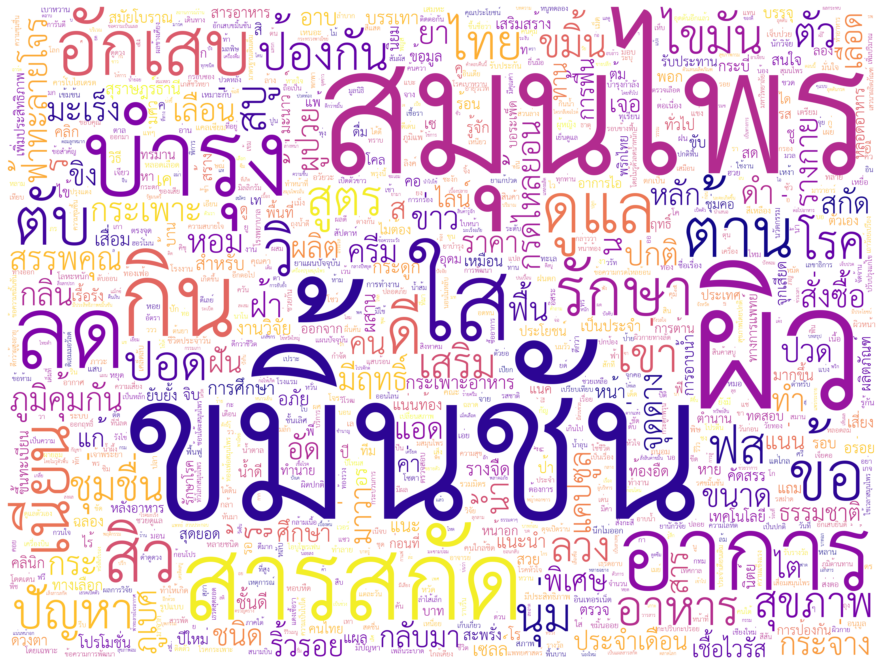

In [14]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

all_text = ''
for ar in docs:
  subtext = " ".join(str(title) for title in ar)
  all_text += subtext

path = '/content/DSI314-association_rules/THSarabunNew.ttf'
regexp = r"[ก-๙a-zA-Z']+"

word_cloud = WordCloud(
                      font_path=path, 
                      relative_scaling = 0.3,
                      min_font_size=1,
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=2000, 
                      colormap='plasma', 
                      scale=3,
                      font_step=4,
                    #   contour_width=3, 
                    #   contour_color='steelblue', 
                      collocations=False,
                      regexp=regexp,
                      margin=2
                      ).generate(all_text)
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(word_cloud, interpolation='bilinear')
ax.axis("off")
fig.show()

นำข้อมูลที่ได้จาก Word Tokenization หาค่า TF-IDF เพื่อหา Keyword ของแต่ละ record

In [16]:
def identity_fun(text):
    return text
    
tfidf_vectorizer = TfidfVectorizer(analyzer = 'word',
                                   tokenizer=identity_fun,
                                   preprocessor=identity_fun,
                                   token_pattern=None)
#สุ่มช่วงของ 5 เอกสารที่ติดกันมาทดลองใช้งาน
tfidf_vector= tfidf_vectorizer.fit_transform(docs[25:30])
tfidf_array = np.array(tfidf_vector.todense())

#แปลงเป็น DataFrame เพื่อง่ายแก่การอ่าน
df_tfidf = pd.DataFrame(tfidf_array,columns=tfidf_vectorizer.get_feature_names())
df_tfidf

,กระจ่าง,กะปริบกะปรอย,การฟื้น,กิน,ก้อน,ขนาด,ขมิ้นชัน,ขัด,ขุน,ข่าว,...,เหยื่อ,แถม,แน่นท้อง,โจร,โดยไม่รู้ตัว,โปร,โปรโมชั่น,ใบ,ใส,ใส่
0,0.207348,0.000000,0.000000,0.00000,0.207348,0.000000,0.000000,0.207348,0.000000,0.000000,...,0.000000,0.414696,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.167287,0.000000
1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.183863,0.000000,0.227894,0.000000,...,0.000000,0.000000,0.000000,0.227894,0.000000,0.227894,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.140857,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.140857,0.000000,0.000000
3,0.000000,0.000000,0.146305,0.29261,0.000000,0.146305,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.146305,0.000000,0.236076,0.146305
4,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.112641,0.000000,0.000000,0.558462,...,0.139615,0.000000,0.139615,0.000000,0.139615,0.000000,0.000000,0.000000,0.000000,0.000000


นำค่าที่ได้ fit กับข้อมูลทั้งหมดที่มี โดยเลือก 10 อันดับแรกที่มีค่า TF-IDF สูงที่สุด

In [17]:
tfidf_vector2 = tfidf_vectorizer.fit_transform(docs)
tfidf_array2 = np.array(tfidf_vector2.todense())
df2 = pd.DataFrame(tfidf_array2,columns=tfidf_vectorizer.get_feature_names())
data = df2.apply(lambda s: s.nlargest(10).index.tolist(), axis=1).ravel()

ตัวอย่าง Keyword ที่ได้จากการหาค่า TF-IDF

In [18]:
data

array([list(['ก', 'กทม', 'กร', 'กรด', 'กรดไหลย้อน', 'กรม', 'กรรม', 'กรรมเก่า', 'กรอง', 'กรอบ']),
       list(['ขมิ้น', 'แดง', 'ประโยชน์', 'ดี', 'ก', 'กทม', 'กร', 'กรด', 'กรดไหลย้อน', 'กรม']),
       list(['เชื้อรา', 'กลิ่น', 'กะ', 'กัญ', 'ควัน', 'คิขุ', 'จิ้ง', 'ตัด', 'ติดตัว', 'ตุ้น']),
       list(['ป้า', 'อาการไอ', 'กทม', 'กรอบ', 'ขีด', 'คัน', 'ชะงัก', 'ซ้ำ', 'ดีเลย์', 'พรุ่งนี้']),
       list(['กระดก', 'ความสบายใจ', 'ชง', 'ซอง', 'น้ำอุ่น', 'ผสม', 'เย็น', 'ชุ่มคอ', 'ดื่ม', 'ออกจาก']),
       list(['ข้อ', 'ข้อสำคัญ', 'ข้อห้าม', 'ท่อ', 'มิลลิกรัม', 'ห้าม', 'เด่น', 'น้ำดี', 'รับประทาน', 'หลังอาหาร']),
       list(['ราคา', 'ววว', 'หมัด', 'อีกแล้ว', 'เพิ่มปริมาณ', 'เห็บ', 'ใช้งาน', 'ข้อความ', 'บาท', 'พิเศษ']),
       list(['กรดไหลย้อน', 'หาย', 'อาการ', 'กระเพาะ', 'รู้', 'อักเสบ', 'จุกคอ', 'ชุด', 'ทัก', 'นอนไม่หลับ']),
       list(['ยินดี', 'รางวัล', 'คัดสรร', 'ปี', 'โร', 'ราคา', 'ครีม', 'พิเศษ', 'หลัก', 'ปกติ']),
       list(['นอน', 'ยง', 'เช้า', 'ใบหน้า', 'พี', 'ดวงตา', 'รอบ', 'เป็นประ

นำ Keyword ได้จากการทำ TF-IDF มาหาค่าความสัมพันธ์โดยใช้ Apriori algorithm

In [19]:
rules = apriori(transactions = data, min_support=0.003, min_confidence=0.01, min_lift=3, min_length=2, max_length=2)
results = list(rules)

def inspect(results):
    lhs         = [tuple(result[2][0][0])[0] for result in results]
    rhs         = [tuple(result[2][0][1])[0] for result in results]
    supports    = [result[1] for result in results]
    confidences = [result[2][0][2] for result in results]
    lifts       = [result[2][0][3] for result in results]
    return list(zip(lhs, rhs, supports, confidences, lifts))

resultsinDataFrame = pd.DataFrame(inspect(results), columns = ['Item #1', 'Item #2', 'Support', 'Confidence', 'Lift'])

ค้นหาคำว่า "ขมิ้นชัน" จากผลลัพธ์ที่ได้ทั้งหมด เรียงลำดับจากค่า Lift ที่มากที่สุด

In [25]:
kamin = resultsinDataFrame.loc[resultsinDataFrame['Item #1'] == 'ขมิ้นชัน']
kamin.nlargest(n=100, columns='Lift')

,Item #1,Item #2,Support,Confidence,Lift
594,ขมิ้นชัน,ขาว,0.0125,0.1,8.000000
632,ขมิ้นชัน,สีเหลือง,0.0125,0.1,8.000000
619,ขมิ้นชัน,ปีใหม่,0.0125,0.1,8.000000
620,ขมิ้นชัน,พริก,0.0125,0.1,8.000000
595,ขมิ้นชัน,ขิง,0.0250,0.2,8.000000
622,ขมิ้นชัน,ฟัง,0.0125,0.1,8.000000
624,ขมิ้นชัน,มีประโยชน์,0.0125,0.1,8.000000
625,ขมิ้นชัน,มีฤทธิ์,0.0250,0.2,8.000000
626,ขมิ้นชัน,ยา,0.0125,0.1,8.000000
629,ขมิ้นชัน,รู้กัน,0.0250,0.2,8.000000


In [26]:
kamin1 = kamin.loc[kamin['Item #2'].isin(['ยา','ต้าน','สุขภาพ','เจ็บป่วย','คุณประโยชน์'])]
kamin1

,Item #1,Item #2,Support,Confidence,Lift
602,ขมิ้นชัน,คุณประโยชน์,0.0125,0.1,8.0
610,ขมิ้นชัน,ต้าน,0.0500,0.4,8.0
626,ขมิ้นชัน,ยา,0.0125,0.1,8.0
633,ขมิ้นชัน,สุขภาพ,0.0125,0.1,4.0
641,ขมิ้นชัน,เจ็บป่วย,0.0250,0.2,8.0
